In [8]:
import sys
from glob import glob
from os import path as osp
from datetime import datetime
from tqdm import tqdm
from skimage import io, transform
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt
from statistics import mean
# torch imports
import torch
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader

# root path of project
from os import path as osp
import sys

# get root directory
import re
reg = '^.*/AquaPose'
project_root = re.findall(reg, osp.dirname(osp.abspath(sys.argv[0])))[0]
sys.path.append(project_root)

from lib.dataset.PoseDataset import PoseDataset
from lib.dataset.CycleDataset import CycleDataset

from lib.models.keypoint_rcnn import get_resnet50_pretrained_model

# utils
from lib.utils.slack_notifications import slack_message
from lib.utils.select_gpu import select_best_gpu
from lib.utils.rmsd import kabsch_rmsd, kabsch_rotate, kabsch_weighted_rmsd, centroid, centroid_weighted, rmsd, rmsd_weighted, kabsch

# references import
# source: https://github.com/pytorch/vision/tree/master/references/detection
from references.engine import train_one_epoch, evaluate
from references.utils import collate_fn

from references.transforms import RandomHorizontalFlip

from lib.matching.matching import *
from lib.utils.visual_utils import *

## Load datasets

In [45]:
train_dirs = [osp.join(project_root,'data/vzf/freestyle/freestyle_1'), osp.join(project_root,'data/vzf/freestyle/freestyle_2'), osp.join(project_root,'data/vzf/freestyle/freestyle_3'), osp.join(project_root,'data/vzf/freestyle/freestyle_4')]

test_dirs = [osp.join(project_root,'data/vzf/freestyle/freestyle_7'), osp.join(project_root,'data/vzf/freestyle/freestyle_8'), osp.join(project_root,'data/vzf/freestyle/freestyle_9'), osp.join(project_root,'data/vzf/freestyle/freestyle_10'), osp.join(project_root,'data/vzf/freestyle/freestyle_11'), osp.join(project_root,'data/vzf/freestyle/freestyle_13'), osp.join(project_root,'data/vzf/freestyle/freestyle_14')] 

train_datasets = [PoseDataset([dir], train = False, cache_predictions=True) for dir in train_dirs]
test_datasets = [PoseDataset([dir], train = False, cache_predictions=True) for dir in test_dirs]

## Select gpu if available

In [46]:
device = select_best_gpu(min_mem=3000) if torch.cuda.is_available() else torch.device('cpu')
cpu = torch.device('cpu')
print(device)
print(cpu)

cuda:0
cpu


## Get model and weights

In [47]:
weight_dir = osp.join(project_root, 'weights')
weight_files = glob(osp.join(weight_dir,'*'))
model = get_resnet50_pretrained_model()
for i, f in enumerate(weight_files):
    print('{}, {}'.format(i,f))
model.load_state_dict(torch.load(weight_files[32], map_location=torch.device('cpu')))


0, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch34-50.wth
1, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch8-50.wth
2, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch12-50.wth
3, /AquaPose/AquaPose/weights/_20-03-2020-23-25_epoch9-10_min_val_loss_10000.wth
4, /AquaPose/AquaPose/weights/_01-04-2020-17-12_epoch29-30_min_val_loss_3.673452949523926.wth
5, /AquaPose/AquaPose/weights/_16-03-2020-14-30_epoch9-10.wth
6, /AquaPose/AquaPose/weights/6_freestyle_ds_20-03-2020-10-00_epoch39-40.wth
7, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch21-50.wth
8, /AquaPose/AquaPose/weights/_16-03-2020-14-11_epoch0-10.wth
9, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch6-50.wth
10, /AquaPose/AquaPose/weights/_17-03-2020-18-01_epoch14-15.wth
11, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch18-50.wth
12, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch14-50.wth
13, /AquaPose/AquaPose/weights/_19-03-2020-07-47_epoch99-100.wth
14, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch

<All keys matched successfully>

In [48]:
_ = model.to(device)
_ = model.eval()

## Make prediction for all test datasets and cache results

In [49]:
for ds in test_datasets:
    ds.predict_all(model)

100%|██████████| 12/12 [00:01<00:00,  7.57it/s]


In [29]:
from lib.eval.pck import pck
metric = pck(test_datasets)
metric.num_kp_visible(model)
pck_score = metric.score_per_keypoint(model,thresholds=[x/100 for x in range(0,55,5)], include_occluded=True)
inversion_error = metric.inversion_errors(model, thresholds=[x/100 for x in range(0,55,5)])


100%|██████████| 12/12 [00:00<00:00, 47.44it/s]


## PCK (percentage correct)

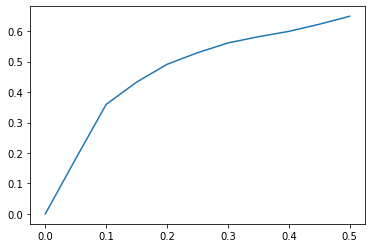

In [50]:
thresholds=[x/100 for x in range(0,55,5)]
for joint in range(5,7,2):
    plt.plot([x for x in thresholds], 0.5 * np.array([s for s in pck_score[joint]]) + 0.5 * np.array([s for s in pck_score[joint +1]]), label=joint)


## Inversion PCK error

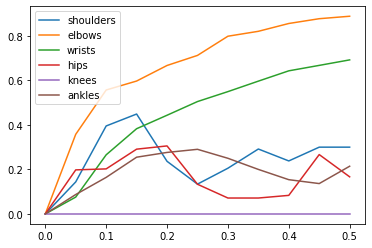

In [51]:
thresholds=[x/100 for x in range(0,55,5)]
joint_groups = ['shoulders', 'elbows', 'wrists', 'hips', 'knees', 'ankles']
for joint, joint_group in zip(range(1,12,2),joint_groups):
    plt.plot([x for x in thresholds], 0.5 * np.array([s for s in inversion_error[joint]]) + 0.5 * np.array([s for s in inversion_error[joint +1]]), label=joint_group)
plt.legend()
plt.show()


## average per joint group (left and right together)

In [52]:
pck_score_merged = [0.5 * np.array([s for s in pck_score[joint]]) + 0.5 * np.array([s for s in pck_score[joint +1]]) for joint in range(1,12,2)]
inversion_error_merged = [0.5 * np.array([s for s in inversion_error[joint]]) + 0.5 * np.array([s for s in inversion_error[joint +1]]) for joint in range(1,12,2)]


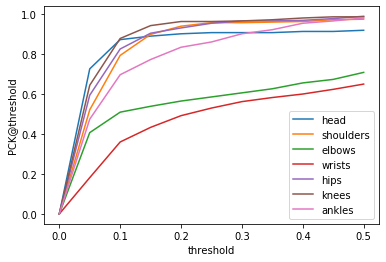

In [53]:
plt.plot(thresholds, pck_score[0], label='head')

joint_groups = ['shoulders', 'elbows', 'wrists', 'hips', 'knees', 'ankles']
for scores, joint in zip(pck_score_merged, joint_groups):
    plt.plot(thresholds, scores, label=joint)
plt.legend()
plt.xlabel('threshold')
plt.ylabel('PCK@threshold')
plt.show()

Text(0, 0.5, 'percentage of inversion errors')

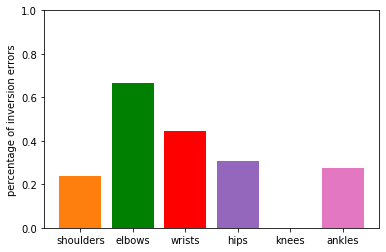

In [57]:
inversion_02 = [inversion_joint[4] for inversion_joint in inversion_error_merged]
plt.bar([x for x in range(0, len(joint_groups))], inversion_02, tick_label=joint_groups, color=['#ff7f0e', 'g', 'red', '#9467bd', '#6c564b', '#e377c2'])
plt.ylim((0.0, 1.0))
plt.ylabel('percentage of inversion errors')

## keypoint similarity curves